<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/PINN_with_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Credits : Mahmoud Asem @Asem000  Septemeber 2021

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit
import matplotlib.pyplot as plt
import sympy as sp

### Generate a a differential equation and its solution using SymPy

In [2]:
t= sp.symbols('t')
f = sp.Function('y')
diffeq = sp.Eq(f(t).diff(t,t) + f(t).diff(t)-t*sp.cos(2*sp.pi*t),0)
sol = sp.simplify(sp.dsolve(diffeq,
                         ics={
                              f(0):1,
                              f(t).diff(t).subs(t,0):10
                              }
                         ).rhs)

In [3]:
diffeq

Eq(-t*cos(2*pi*t) + Derivative(y(t), t) + Derivative(y(t), (t, 2)), 0)

In [4]:
sol

(2*pi*t*exp(t)*sin(2*pi*t) + 8*pi**3*t*exp(t)*sin(2*pi*t) - 16*pi**4*t*exp(t)*cos(2*pi*t) - 4*pi**2*t*exp(t)*cos(2*pi*t) + 16*pi**3*exp(t)*sin(2*pi*t) + exp(t)*cos(2*pi*t) + 12*pi**2*exp(t)*cos(2*pi*t) - exp(t) + 36*pi**2*exp(t) + 336*pi**4*exp(t) + 704*pi**6*exp(t) - 640*pi**6 - 304*pi**4 - 44*pi**2)*exp(-t)/(4*pi**2*(1 + 8*pi**2 + 16*pi**4))

In [5]:
#verify solution
sp.simplify(-t*sp.cos(sp.pi*2*t)+sol.diff(t)+sol.diff(t,t))

0

### Constructing the MLP

In [8]:
# Simple MLP to estimate f(t)~NN(t)
# NN is composed of single input (t) and single output f(t)

# MLP
# 1) initialize params
# 2) perform prediction (forward pass)
# 3) Compute loss
# 4) update params (backward pass)
# 5) iterate from 2)


def init_params(layers):
  params = [ ]
  for n_in,n_out in zip(layers[:-1],layers[1:]):
    params.append(
        {'W':np.random.normal(size=(n_in,n_out))*np.sqrt(2/n_in),
         'B':np.random.normal(size=(n_out))}
         )
  return params

def fwd(params,X):
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']



def loss_fun(params,X):

  #autograd version
  y = lambda X : fwd(params,X)
  dydx=lambda X:jax.grad(lambda X:jnp.sum(y(X)))(X)
  ddyddx=lambda X:jax.grad(lambda X : jnp.sum(dydx(X)))(X)

  # the ode encoded in the loss function
  ode_loss = jnp.mean((ddyddx(X)+dydx(X)-X*jnp.cos(2*jnp.pi*X))**2)

  # Initial point t=0
  p = jnp.array([[0.0]])

  #Initial conditions y(0) =1 and dydt(0) = 10 
  ics_loss = jnp.mean((y(p)-1)**2) + jnp.mean((dydx(p)-10)**2)

  return  ode_loss + ics_loss 

@jax.jit
def update(params,X,LR=1e-3):
  # Get the gradient w.r.t to MLP params
  grads=jax.grad(loss_fun,0)(params,X)
  #Update params
  return jax.tree_multimap(lambda params,grads : params-LR*grads, params,grads)

In [9]:
%%time 
x= jnp.linspace(0,jnp.pi,100).reshape(-1,1)

# construct the MLP of  4 hidden layers of 20 neurons for each layer
params = init_params([1,20,20,20,20,1])

# Iterate 100K times
for _ in range(10_000):

  # learning rate scheduler 
  if    _<1_000 : LR = 1e-2
  elif  _<3_000 : LR = 5e-3
  elif  _<5_000 : LR = 1e-3
  elif  _<7_000 : LR = 5e-4
  elif  _<10_000 : LR = 1e-4

  params = update(params,x,1e-4)

  # print loss and epoch info
  if _ %1000 ==0:
    print(f'Epoch={_}\tLR= {LR}\tloss={loss_fun(params,x):.3f}')

Epoch=0	LR= 0.01	loss=104.158
Epoch=1000	LR= 0.005	loss=5.401
Epoch=2000	LR= 0.005	loss=2.623
Epoch=3000	LR= 0.001	loss=2.193
Epoch=4000	LR= 0.001	loss=1.977
Epoch=5000	LR= 0.0005	loss=1.800
Epoch=6000	LR= 0.0005	loss=1.658
Epoch=7000	LR= 0.0001	loss=1.559
Epoch=8000	LR= 0.0001	loss=1.496
Epoch=9000	LR= 0.0001	loss=1.456
CPU times: user 8.55 s, sys: 80.1 ms, total: 8.63 s
Wall time: 8.65 s


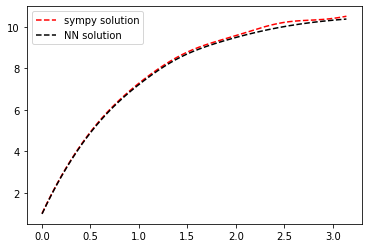

In [10]:
lam_sol= sp.lambdify(t,sol)

dT = 1e-3
Tf = jnp.pi
T = np.arange(0,Tf+dT,dT)


sym_sol =np.array([lam_sol(i) for i in T])

plt.plot(T,sym_sol,'--r',label='sympy solution')
plt.plot(T,fwd(params,T.reshape(-1,1))[:,0],'--k',label='NN solution')
plt.legend()